In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!cd  model

In [0]:
## To get the data type
## 

!unzip -e Flickr_Data.zip -d /root/dataset

Archive:  Flickr_Data.zip
   creating: /root/dataset/Flickr_Data/Flickr_TextData/
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/CrowdFlowerAnnotations.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/ExpertAnnotations.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/Flickr8k.lemma.token.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/Flickr8k.token.txt  
  inflating: /root/dataset/Flickr_Data/Flickr_TextData/readme.txt  
   creating: /root/dataset/Flickr_Data/flickr8ktextfiles/
 extracting: /root/dataset/Flickr_Data/flickr8ktextfiles/flickr_8k_train_dataset.txt  
  inflating: /root/dataset/Flickr_Data/flickr8ktextfiles/flickr_8k_val_dataset.txt  
   creating: /root/dataset/Flickr_Data/Images/
  infl

In [0]:
cd /root/dataset/Flickr_Data

/root/dataset


In [0]:
ls

flickr8ktextfiles/  Flickr_TextData/  Images/


### Importing Important Libraries

In [2]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
#from image_processing import processing

In [3]:
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation,BatchNormalization, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image, sequence

Using TensorFlow backend.


In [0]:
captions = open('Flickr_TextData/Flickr8k.token.txt', 'r').read().split("\n")
x_train = open('Flickr_TextData/Flickr_8k.trainImages.txt', 'r').read().split("\n")
x_val = open('Flickr_TextData/Flickr_8k.devImages.txt', 'r').read().split("\n")
x_test = open('Flickr_TextData/Flickr_8k.testImages.txt', 'r').read().split("\n")

In [0]:
(len(captions)-1)

40460

#### Changing format to
D

In [0]:
caption = {}

for i in range(len(captions)-1):
    #print(captions[i].split("#"))
    try:
        photo, cap  = captions[i].split("#")
        cap_ = '<start> '+ cap[2:] + ' <end>'
    except:
        pass
    if photo in caption:
        caption[photo].append(cap_)
    else:
        caption[photo] = [cap_]
        
        

In [0]:
print(len(caption))
len(x_train)

8092


6001

In [0]:
capt = list(caption.keys())
            

In [0]:
def gen_dataset(dataset,caption,train):  
    for img in train:
        if img == '':
            continue
        for capt in caption[img]:
            dataset.write((img+"\t"+capt+"\n").encode())
            dataset.flush()
    dataset.close()



In [0]:
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")




18

In [0]:
gen_dataset(train_dataset,caption,x_train)
gen_dataset(test_dataset,caption,x_test)
gen_dataset(val_dataset,caption,x_val)


In [0]:
train_dataset = open('flickr_8k_train_dataset.txt','rb')
len(train_dataset.readlines())

30000

In [ ]:
ras_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [34]:
import numpy as np
from PIL import Image as pilimage
from keras.applications.vgg16 import VGG16
from keras.models import  Model
def processing(image_name,model = None,get_histogram = False,size = None,convert_BGR = True,image_path = 'flickr30k-images/', mean_of_data = [104,117,124], return_arr = False):
       
        
    '''
    Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that
    feature or pixel as well if you want to normalize each feature value to a z-score. 
    
    PARAMETER:
    image_name --> name of the image
    model --> want to extract feature then give the model
    get_histogram --> Boolean getting histogram
    size --> If resize give to tuple in form of (width,height)
    convert_BGR--> convert to BGR Boolen type
    mean)of_data --> to normalize the data in order of the channel
    
    RETURN:
    pred_value if model given.A coloumn array.
    im_arr image array
    '''
    if model == None:
        
        base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
        model = Model(base_model.input, base_model.layers[-2].output)
        
    path = image_path + str(image_name)
    with pilimage.open(path) as image:
        if not(size == None):
            image = image.resize(size)
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
        im_arr = np.expand_dims(im_arr, axis=0)
    
    
    
    if get_histogram == True:
        print(image.histogram())

    if convert_BGR == True:
        im_arr = im_arr[ :,:, :, ::-1]
    if not(mean_of_data == None):
        im_arr[ :,:, :, 0] -= mean_of_data[0]
        im_arr[ :,:, :, 1] -= mean_of_data[1]
        im_arr[ :,: ,:, 2] -= mean_of_data[2]
        
    if not(model == None):    
        pred = model.predict(im_arr)
        pred = np.reshape(pred, pred.shape[1])
        if return_arr == False:
            return pred
        if return_arr == True:
            return pred, im_arr
    
    return im_arr

In [0]:
train_data = {}

temp=0
for i in x_train:
    try:
        images_path="Images/"
        path = images_path + i
        train_data[i]  = processing(i,size = (224,224),convert_BGR=False,model = ras_model
                        ,mean_of_data=[0,0,0],return_arr=False,image_path= images_path) # local module
    except:
        pass


In [0]:
train_data = {}

temp=0
for i in tqdm(x_train):
    try:
        images_path="Images/"
        path = images_path + i
        train_data[i]  = processing(i,size = (224,224),convert_BGR=False,model = ras_model
                        ,mean_of_data=[0,0,0],return_arr=False,image_path= images_path) # local module
    except:
        pass



  0%|          | 0/6001 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

100%|██████████| 6001/6001 [01:25<00:00, 69.79it/s]

In [0]:
with open( "/content/drive/My Drive/datasetss/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [0]:
ds = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t').values

print(ds.shape)

(29999, 2)


In [0]:
ds[0:5]

array([['2513260012_03d33305cf.jpg',
        '<start> A black dog is running after a white dog in the snow . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Black dog chasing brown dog through snow <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs chase each other across the snowy ground . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs play together in the snow . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs running through a low lying body of water . <end>']],
      dtype=object)

In [0]:
all_caption = []
for i in range(ds.shape[0]):
    all_caption.append(ds[i, 1])
    
print(len(all_caption))

29999


In [0]:
words = [i.split() for i in all_caption]

In [0]:
vocabulary = []
for i in words:
    vocabulary.extend(i)
vocabulary = list(set(vocabulary))

print(len(vocabulary))

vocab_size = len(vocabulary) +1
vocab_size

8253


8254

In [0]:
word_in = {val:index+1 for index, val in enumerate(vocabulary)}
in_word = {index+1:val for index, val in enumerate(vocabulary)}

In [0]:
in_word[0] = "ravi"
word_in['ravi'] = 0

In [0]:
max_len = 40
padded_sequences, subsequent_words = [], []
for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_in[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(29999,)
(29999,)


In [0]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])
for ix in tqdm(range(4000,4000+num_of_images)):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])
np.save("/content/drive/My Drive/datasetss/captions.npy", captions)
np.save("/content/drive/My Drive/datasetss/next_words.npy", next_words)
print(captions.shape)
print(next_words.shape)


100%|██████████| 2000/2000 [09:41<00:00,  1.78it/s]


(25697, 40)
(25697, 8254)


In [0]:
image_names = []

for ix in tqdm(range(4000,6000)):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
image_names = np.asarray(image_names)

np.save("/content/drive/My Drive/datasetss/image_names.npy", image_names)

print(len(image_names))


100%|██████████| 2000/2000 [00:00<00:00, 182234.27it/s]

25697


In [0]:
with open('/content/drive/My Drive/datasetss/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f)
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(29999, 2048)


In [0]:
images = []

for ix in tqdm(range(4000,6000)):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)


100%|██████████| 2000/2000 [00:00<00:00, 96369.83it/s]

(25697, 2048)


In [6]:


embedding_size = 128
max_len = 40



image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(BatchNormalization())
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,784
Trainable params: 262,528
Non-trainable params: 256
_________________________________________________________________


In [8]:

language_model = Sequential()

language_model.add(Embedding(input_dim=8254, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(275, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 275)           444400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           35328     
Total params: 1,536,240
Trainable params: 1,536,240
Non-trainable params: 0
_________________________________________________________________


In [11]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(150, return_sequences=True)(conca)
x = LSTM(550, return_sequences=False)(x)
x = Dense(8254)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.load_weights("model/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
batch_norm

In [0]:
% cd /content/drive/My Drive/datasetss

/content/drive/My Drive/datasetss


In [0]:
model.load_weights('model_weights1.h5')
hist = model.fit([images, captions], next_words, batch_size=512, epochs=225)

Epoch 1/225
25697/25697 [==============================] - 20s 779us/step - loss: 5.7266 - acc: 0.2628
Epoch 2/225
25697/25697 [==============================] - 14s 556us/step - loss: 4.2542 - acc: 0.3153
Epoch 3/225
25697/25697 [==============================] - 14s 564us/step - loss: 3.6409 - acc: 0.3580
Epoch 4/225
25697/25697 [==============================] - 14s 562us/step - loss: 3.2257 - acc: 0.3977
Epoch 5/225
25697/25697 [==============================] - 14s 553us/step - loss: 2.8797 - acc: 0.4319
Epoch 6/225
25697/25697 [==============================] - 14s 552us/step - loss: 2.5793 - acc: 0.4681
Epoch 7/225
25697/25697 [==============================] - 14s 553us/step - loss: 2.2991 - acc: 0.5112
Epoch 8/225
25697/25697 [==============================] - 14s 554us/step - loss: 2.0543 - acc: 0.5482
Epoch 9/225
25697/25697 [==============================] - 14s 557us/step - loss: 1.8191 - acc: 0.5863
Epoch 10/225
25697/25697 [==============================] - 14s 556us/ste

In [0]:
model.save('model_weights.h5')

In [0]:
# def beam_search_predictions(imag, beam_index = 3,max_len  = 40):
#     #print(imag)
#     #imag,_ = processing(imag,get_histogram=False,size = (224,224),model = feature
#      #              ,image_path='/root/flickr30k-images/',return_arr = True)
#     #imag = imag.reshape((1,4096))
    
#     start = [word_in["<start>"]]
    
#     start_word = [[start, 0.0]]
    
#     while len(start_word[0][0]) < max_len:
#         temp = []
#         for s in start_word:
#             par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
#             preds = model.predict([np.array([imag]), np.array(par_caps)])
            
#             word_preds = np.argsort(preds[0])[-beam_index:] #Top n prediction
            
#             for w in word_preds: #new list so as to feed it to model again
#                 next_cap, prob = s[0][:], s[1]
#                 next_cap.append(w)
#                 prob += preds[0][w]
#                 temp.append([next_cap, prob])
                    
#         start_word = temp
#         start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
#         start_word = start_word[-beam_index:] # Top n words
    
#     start_word = start_word[-1][0]
#     intermediate_caption = [in_word[i] for i in start_word]

#     final_caption = []
    
#     for i in intermediate_caption:
#         if i != '<end>':
#             final_caption.append(i)
#         else:
#             break
    
#     final_caption = ' '.join(final_caption[1:])
#     return final_caption

In [0]:
cd /root/dataset/Flickr_Data/

/root/dataset/Flickr_Data


In [0]:
images = os.listdir("Images")

In [13]:
import json
with open('model/word_in.json') as json_data:
    word_in = json.load(json_data)

with open('model/in_word.json') as json_data:
    in_word = json.load(json_data)

In [40]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_in[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = in_word[str(np.argmax(preds[0]))]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

#Argmax_Search = predict_captions(pred_test)


In [52]:
photo = os.listdir("images")

In [53]:
from PIL import Image as pilimage
from IPython.display import Image as ipython_img  
def get_caption(input_image):
    
    images_path='Images/'
  
    filename=images_path+input_image
    z_ = ipython_img(filename)
    display(z_)  
    pred_test = processing(input_image,size = (224,224),convert_BGR=False,model = ras_model
                          ,mean_of_data=[0,0,0],return_arr=False,image_path=images_path) # local module
    Argmax_Search = predict_captions(pred_test)
    print(Argmax_Search)


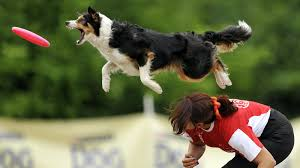

C:\Users\RAVISINGH\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


A brown dog jumps to catch a ball with front it .


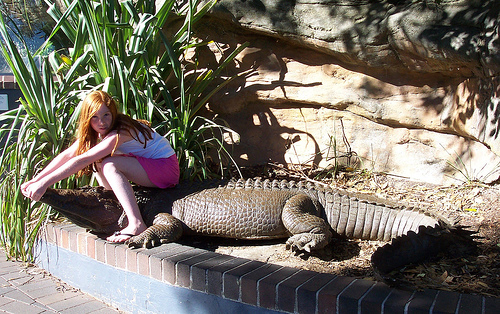

A girl plays in a small small tossing a leash in a inflatable bottle .


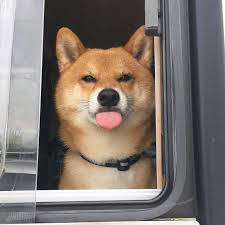

A dog is jumping through a red mouth holding the mouth , background .


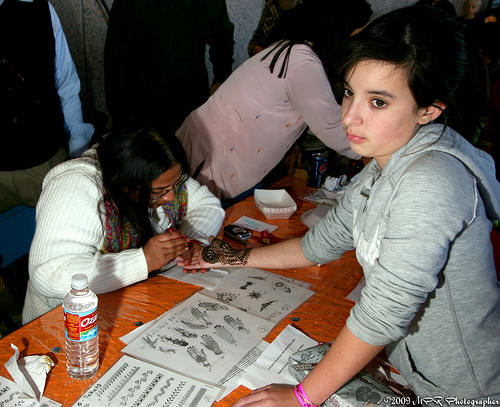

Two young woman in a white shirt poses up the street while another woman walks a woman that people behind the crowd it .


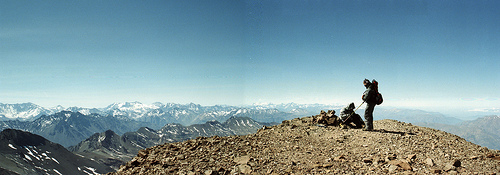

Three bicyclists are on on a cliff .


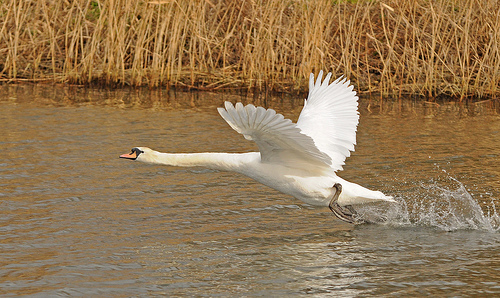

A surfer leaps in water 's edge near the edge .


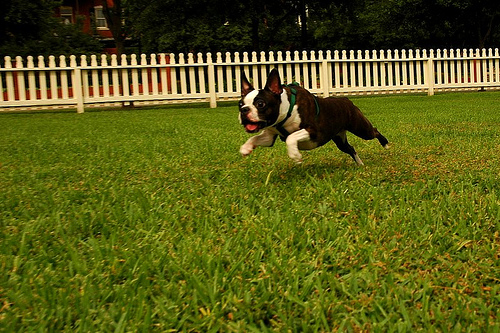

A dog jumps with catch catch a ball .


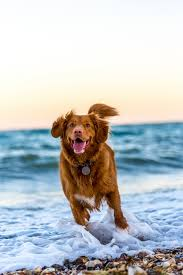

A dog is running through of a field .


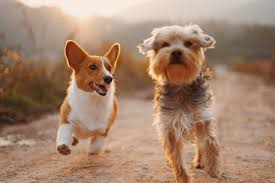

A small dog and and a brown dog playing .


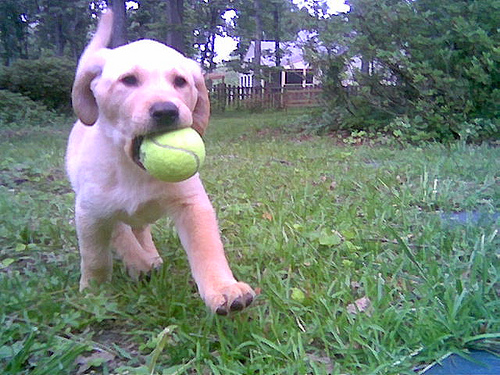

A dog catching a Frisbee


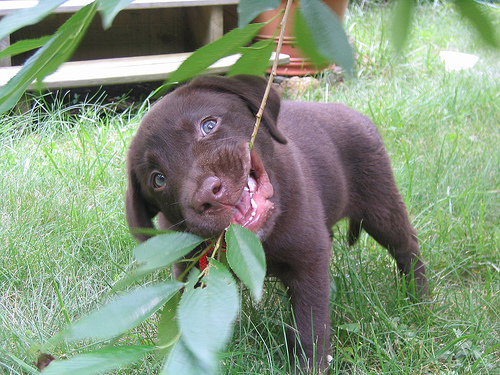

A young brown puppy pulls a leafy branch in his teeth in a backyard .


In [54]:
for i in photo:
    try:
        get_caption(i)
    except:
            pass